# **Hate Speech Detector**

## **Model "Hate-speech-CNERG/dehatebert-mono-german"**

## 1. Load and prepare data

In [1]:
import pandas as pd
from google.colab import files
import io
uploaded = files.upload()

Saving hatespeech.csv to hatespeech.csv


In [2]:
df = pd.read_csv(io.BytesIO(uploaded['hatespeech.csv']),lineterminator='\n')

In [3]:
df.drop('Unnamed: 0',inplace=True,axis=1)

In [4]:
#shuffle data
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df.head()

,message,HateSpeech
0,Du steckst mittendrin? Was bedeutet das?,0
1,Das hängt ziemlich weit oben. Brauche Kompliz...,0
2,"Wie die NYPD mitteilte, sei das Fahrzeug im Ma...",0
3,"Man kann gar nicht glauben, dass Mutti so blin...",1
4,Das ist Kapitalismus in der schärfsten Form......,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19379 entries, 0 to 19378
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   message     19379 non-null  object
 1   HateSpeech  19379 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 302.9+ KB


In [7]:
df.shape

(19379, 2)

In [8]:
df['HateSpeech'].value_counts()

0    15138
1     4241
Name: HateSpeech, dtype: int64

## 2. Deep Learning

## 2.1. Install Simple Transformers library

In [9]:
# install simpletransformers
!pip install simpletransformers

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.28.2

simpletransformers==0.63.3


## 2.2. Select a pre-trained language model

Simple Transformers library is based on the Transformers library from HuggingFace. This enables to use every pre-trained model provided in the Transformers library and all community-uploaded models. For a list of models refer to https://huggingface.co/models.

## 2.3. Train Test Split


In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.20)

print('train shape: ',train_df.shape)
print('test shape: ',test_df.shape)

train shape:  (15503, 2)
test shape:  (3876, 2)


## 2.4. Load pre-trained model

https://huggingface.co/Hate-speech-CNERG/dehatebert-mono-german

In [11]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "threshold": 0.6,
             "num_train_epochs": 10,
             'train_batch_size': 100,
             'use_early_stopping': True,
             'optimizer': 'AdamW',
             'early_stopping_metric': 'eval_loss' 
             }

# Create a ClassificationModel
dehatebert_mono_german_m = ClassificationModel(
    "bert", "Hate-speech-CNERG/dehatebert-mono-german",
    num_labels=2,
    weight=[0.5, 5],
    args=train_args,
    ignore_mismatched_sizes=True
)

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/152 [00:00<?, ?B/s]

## 2.5. Train model

In [12]:
# Train the model
dehatebert_mono_german_m.train_model(train_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/15503 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

(1560, 0.4188658526000113)

## 3. Evaluation

## 3.1. Results

In [13]:
from sklearn.metrics import f1_score, accuracy_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = dehatebert_mono_german_m.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)

result

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3876 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/485 [00:00<?, ?it/s]

{'mcc': 0.34254276966193326,
 'tp': 591,
 'tn': 2126,
 'fp': 913,
 'fn': 246,
 'auroc': 0.7735425136310402,
 'auprc': 0.5282159209679944,
 'f1': 0.7009803921568627,
 'acc': 0.7009803921568627,
 'eval_loss': 0.8477303998717635}

## 3.2. Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'True lables'
    cm.columns.name = 'Predicted labels'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [15]:
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

true = test_df['HateSpeech'].tolist()
predicted = lst

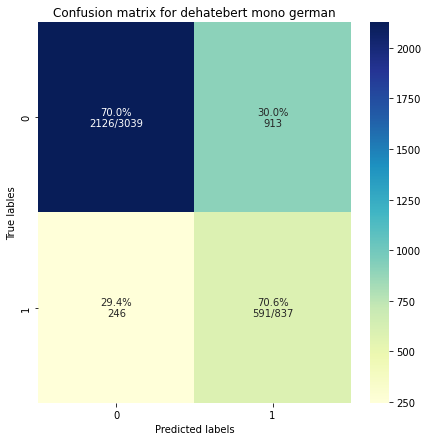

In [16]:
plot_cm(true, predicted, 'Confusion matrix for dehatebert mono german', figsize=(7,7))

## 3.3. Classification report

In [17]:
from sklearn import metrics
print(metrics.classification_report(true, predicted, digits=3))

              precision    recall  f1-score   support

           0      0.896     0.700     0.786      3039
           1      0.393     0.706     0.505       837

    accuracy                          0.701      3876
   macro avg      0.645     0.703     0.645      3876
weighted avg      0.788     0.701     0.725      3876



## 4. Predictions

In [20]:
class_list = ['Other','Hate Speech']

test_tweet = 'Muslime entwickeln sich langsam aber stetig zu einem bösartigen Tumor der dringend entfernt werden muss'

predictions, raw_outputs = dehatebert_mono_german_m.predict([test_tweet])

print(class_list[predictions[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Other


In [19]:
class_list = ['Other','Hate Speech']

test_tweet = 'Während in Glasgow verhandelt wird, blockiert eine kleine Gruppe von Aktivisten die Straßen um London.'

predictions, raw_outputs = dehatebert_mono_german_m.predict([test_tweet])

print(class_list[predictions[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Other
